# Project 3 - Detecting Pneumonia from X-ray Images

### 1. Introduction & Objectives

This notebook focuses on developing a Convolutional Neural Network (CNN) for the detection of Pneumonia from chest X-ray images. The primary objective is to create a robust model that can serve as a valuable tool to assist radiologists in accurately diagnosing Pneumonia. By leveraging a dataset containing both Pneumonia-positive and normal chest X-ray images, we aim to:

- Preprocess and analyze medical imaging data effectively.
- Implement a transfer learning-based CNN model optimized for binary classification.
- Evaluate the model's performance using clinically relevant metrics, such as precision, recall, and F1-score.

Through this project, we aim to address challenges unique to medical image classification, such as handling class imbalance and ensuring ethical considerations are incorporated into model evaluation and application.

### 2. Data Understanding

The dataset used in this project comprises 5,856 chest X-ray images in JPEG format. Since the images vary in size, they will be resized to a standard dimension of 224x224 pixels for model compatibility. The dataset is organized into three main subdirectories: `train`, `val`, and `test`, each further categorized into two classes: `NORMAL` and `PNEUMONIA`. The distribution of images across these directories is as follows:

- **Training Set:** Contains 5,216 images, with 3,875 labeled as Pneumonia and 1,341 as Normal.
- **Validation Set:** Comprises 16 images, evenly distributed with 8 Pneumonia images and 8 Normal images.
- **Test Set:** Consists of 624 images, including 390 Pneumonia images and 234 Normal images.

This class imbalance, particularly in the training set, highlights the need for strategies like class weighting or data augmentation to ensure fair model training and improved generalization.

#### 2.1 Environment Setup

To ensure a streamlined and efficient workflow, we will suppress TensorFlow warnings to reduce unnecessary console clutter. The Keras backend will be configured to use TensorFlow. Additionally, we provide an option to disable GPU usage for flexibility. By setting the `use_gpu` flag to `False`, the notebook will run computations on the CPU instead of the GPU, allowing adaptability to various hardware environments.

In [1]:
# Supress TensorFlow warnings and set the Keras backend to TensorFlow
import os
import sys

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Redirect stderr to null
sys.stderr = open(os.devnull, 'w')

# Set the flag to disable the GPU
use_gpu = True

In [2]:
if not use_gpu:
    # Disable the GPU
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

    print("GPU is disabled.")
else:
    # Set the GPU device
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'

    # Optimize GPU memory allocation
    os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

    # Enable XLA JIT compilation
    os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices"

    # Disable unnecessary logging
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

    # Maximize GPU usage
    os.environ["TF_ENABLE_GPU_GARBAGE_COLLECTION"] = "false"

    # Advanced GPU optimizations
    os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
    os.environ["TF_FORCE_UNIFIED_MEMORY"] = "1"
    os.environ["TF_ENABLE_AUTO_MIXED_PRECISION"] = "1"

    print("GPU is enabled.")

GPU is enabled.


The environment setup is complete. Next, we will proceed with importing the necessary libraries required for this project.

#### 2.2 Importing Libraries

In this section, we import the libraries necessary for building, training, and evaluating our Pneumonia classification model. We will leverage TensorFlow and Keras for deep learning tasks, as well as other libraries for data visualization and model evaluation.

In [3]:
# Importing Libraries
import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from keras.src.optimizers import Adam
from keras.api.regularizers import l2
from keras.api.models import load_model
from sklearn.utils import compute_class_weight
from keras.src import Sequential, Input, Model
from keras.src.callbacks import ModelCheckpoint
from keras.src.utils import image_dataset_from_directory
from keras.src.applications.efficientnet_v2 import EfficientNetV2B0
from keras.api.layers import RandomFlip, RandomZoom, RandomRotation, RandomBrightness
from keras.src.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

The libraries have been successfully imported. Next, we will proceed with loading the data from the specified directory structure.

#### 2.3 Loading the Data

The dataset will be loaded from the `Inputs/chest_xray` directory, which is structured into three subdirectories: `train`, `val`, and `test`. Each of these subdirectories contains further subdirectories, `NORMAL` and `PNEUMONIA`, representing the two classes.

We will use TensorFlow's `image_dataset_from_directory` utility to load and preprocess the data directly from this directory structure. This approach simplifies the data-loading process, ensuring that the images are automatically labeled based on their folder names. Additionally, this method allows for efficient batching and data shuffling during model training.

In [4]:
# Load the data
base_dir = Path('../Inputs/chest_xray')

train_dataset = image_dataset_from_directory(base_dir / 'train', labels='inferred', label_mode='int',
                                             batch_size=32, image_size=(224, 224))
val_dataset = image_dataset_from_directory(base_dir / 'val', labels='inferred', label_mode='int', batch_size=32,
                                           image_size=(224, 224))
test_dataset = image_dataset_from_directory(base_dir / 'test', labels='inferred', label_mode='int',
                                            batch_size=32, image_size=(224, 224))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


The data has been successfully loaded. Next, we will analyze the class distribution to understand the balance between the `NORMAL` and `PNEUMONIA` classes in the dataset.

#### 2.4 Analyzing the Class Distribution

In this step, we will analyze the class distribution within the training dataset. Understanding the proportion of `NORMAL` and `PNEUMONIA` images is crucial to identify any class imbalance, which may impact the model's performance and training process. This analysis will guide decisions regarding techniques like class weighting or data augmentation to mitigate imbalance-related issues.

In [5]:
# Analyze the class distribution for binary classification
class_counts = {0: 0, 1: 0}

for _, labels in train_dataset.unbatch():
    label = labels.numpy()
    class_counts[label] += 1

print("Class distribution:", class_counts)

Class distribution: {0: 1341, 1: 3875}


The training dataset contains 3,875 Pneumonia images and 1,341 Normal images, highlighting a significant class imbalance. To address this, we will compute class weights, which will be used during training to ensure that the model gives appropriate importance to both classes, thereby improving its generalization and performance on imbalanced data.

In [6]:
# Extract labels from the dataset
all_labels = []

for _, labels in train_dataset.unbatch():
    all_labels.append(labels.numpy())

all_labels = np.array(all_labels)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights = dict(enumerate(class_weights))
print(f"Class weights: {class_weights}")

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


The class weights have been successfully computed, where class 0 represents `Normal` and class 1 represents `Pneumonia`. These weights will be applied during model training to ensure the model does not become biased toward the majority class.

Next, we will examine the image sizes to ensure uniformity and identify any preprocessing requirements.

#### 2.5 Checking the Image Sizes

In this step, we will verify whether all images in the dataset have consistent dimensions. Uniform image sizes are essential for feeding the data into the neural network. If discrepancies are found, we will resize the images to ensure compatibility with the model architecture.

In [7]:
# Check if the images are of the same size
for images, _ in train_dataset.take(1):
    print("Image sizes:", images.shape)

Image sizes: (32, 224, 224, 3)


The images are confirmed to be of the same size, with dimensions `(224, 224, 3)` for each image and a batch size of 32. This uniformity ensures compatibility with the neural network.

Next, we will proceed to visualize a few samples from the dataset to gain a better understanding of the data.

#### 2.6 Visualizing the Data

In this step, we will visualize a few samples from the training dataset. This helps us better understand the dataset and verify the integrity and quality of the images. By inspecting examples from both the `NORMAL` and `PNEUMONIA` classes, we can also gain insights into potential challenges in distinguishing between the two classes.

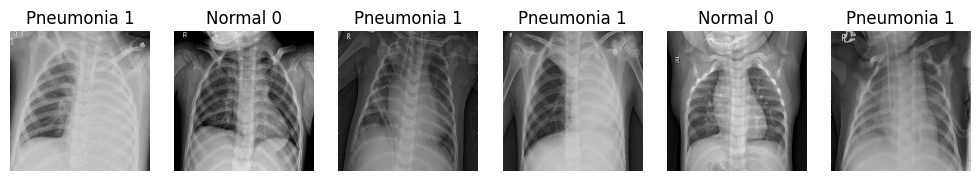

In [8]:
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):
    for i in range(6):
        plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        plt.title(f"Normal {labels[i]}" if labels[i] == 0 else f"Pneumonia {labels[i]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

The data visualization is complete. The label `1` indicate `Pneumonia`, while `0` indicate `Normal`. It is important to note that for individuals without medical expertise, the images from both classes might appear too similar to differentiate. This emphasizes the need for a robust and precise model to assist in accurate classification.

Next, we will proceed with preprocessing the data to prepare it for training.

#### 2.7 Preprocessing the Data

EfficientNetV2 models do not require explicit normalization of pixel values to a specific range like `[0, 1]`. Instead, they are designed to handle input images with pixel values in the range `[0, 255]`. To ensure compatibility, we will verify that the pixel values fall within this range.

In [9]:
for images, labels in train_dataset.take(1):
    print(f"Pixel range: {tf.reduce_min(images).numpy()} to {tf.reduce_max(images).numpy()}")

Pixel range: 0.0 to 255.0


The pixel values fall within the expected range of `[0, 255]`, confirming that the images are properly prepared for training with the EfficientNetV2 model.

Next, we will proceed to build the model.

### 3. Model Building

In this section, we will construct a Convolutional Neural Network (CNN) based on the EfficientNetV2 architecture. EfficientNetV2 is a state-of-the-art model known for its superior performance and efficiency, particularly in medical imaging tasks. To tailor the model for our binary classification problem, we will modify its architecture by adding custom layers to the base model. These additional layers will enhance the network's ability to distinguish between `NORMAL` and `PNEUMONIA` cases.

#### 3.1 Data Augmentation

To enhance the model's generalization and robustness, we will apply a variety of advanced data augmentation techniques to the training dataset. These augmentations will include:

- **Random Flip:** Flip images horizontally to simulate variations in image orientation.
- **Random Rotations:** Rotate images to capture variations in the angle of the X-rays.
- **Random Zooms:** Apply random zooms to simulate different distances or scales of medical images.
- **Random Brightness Adjustments:** Vary the brightness to simulate different lighting conditions.

These techniques help simulate real-world variations in medical imaging, improving the model's ability to generalize and reducing the risk of overfitting. By creating a more diverse training set, we aim to enhance the model's performance on unseen data.

In [10]:
# Advanced Data Augmentation
data_augmentation = Sequential(
    [
        RandomFlip('horizontal'),
        RandomRotation(0.25),
        RandomZoom(0.25),
        RandomBrightness(0.25)
    ],
    name='Advanced_Data_Augmentation_Layer'
)

The data augmentation layer has been successfully set up. Next, we will proceed to build the model by integrating the EfficientNetV2 architecture and adding custom layers for our Pneumonia classification task.

#### 3.2 Building the Model

In this step, we will build the Convolutional Neural Network (CNN) using the EfficientNetV2B0 architecture as the base model. We will unfreeze some layers of the base model to allow fine-tuning, enabling the model to adapt better to our specific dataset. By leveraging transfer learning, we can benefit from the pretrained knowledge of EfficientNetV2 while customizing it for the task of Pneumonia classification.

To tailor the model to this task, the following custom layers are added:

- **GlobalAveragePooling2D:** This layer reduces the spatial dimensions of the feature maps, helping the model learn compact, high-level representations of the extracted features.
- **Dense Layer:** A dense layer with 512 units and ReLU activation is added to introduce non-linearity and increase model complexity.
- **BatchNormalization:** Batch normalization layers are applied to stabilize and accelerate the training process.
- **Dropout Layers:** Dropout is applied with a rate of 0.25 after each dense layer, which helps in reducing overfitting by randomly deactivating neurons during training.
- **Output Layer:** A final dense layer with a sigmoid activation function outputs a probability for the binary classification task, distinguishing between `Normal` and `Pneumonia`.

This model architecture strikes a balance between leveraging the pretrained EfficientNetV2 base and adding sufficient complexity to adapt it to our specific classification problem.

In [11]:
# Loading the pre-trained EfficientNetV2B0 model
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Input layer
inputs = Input(shape=(224, 224, 3))

# Model layers
x = data_augmentation(inputs)
x = base_model(x)
x = GlobalAveragePooling2D()(x)

# Custom dense layers
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# Output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs, outputs, name='Pneumonia_Detection_Model')

# Display the model summary
model.summary()

Model: "Pneumonia_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Advanced_Data_Augmentation_Lay… │ (None, 224, 224, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,577,745 (25.09 MB)

 Trainable params: 657,409 (2.51 MB)

 Non-trainable params: 5,920,336 (22.58 MB)

The model has been successfully constructed with a total of **6,577,745** parameters, of which **657,409** are trainable. This setup allows the EfficientNetV2 base to retain its pretrained knowledge while fine-tuning the custom layers to better adapt to our specific classification task.

Next, we will compile and train the model to initiate the learning process.

#### 3.3 Compiling and Training the Model

In this step, we will compile the model using the Adam optimizer, which is well-suited for deep learning tasks due to its adaptive learning rate capabilities. The loss function will be binary cross-entropy, appropriate for our binary classification task. Additionally, the class weights computed earlier will be applied during training to address the class imbalance in the dataset.

To ensure optimal model performance, we will use the `ModelCheckpoint` callback to save the model with the best validation performance during training. This approach prevents overfitting and ensures the most effective model is retained.

In [12]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

# Define the callbacks
callbacks = [
    ModelCheckpoint(
        filepath="../Models/Chest_X-Ray_Pneumonia_Detection_Model.keras",
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    )
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - Precision: 0.9255 - Recall: 0.6633 - accuracy: 0.7139 - loss: 1.2309
Epoch 1: val_loss improved from inf to 1.05196, saving model to ../Models/Chest_X-Ray_Pneumonia_Detection_Model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - Precision: 0.9259 - Recall: 0.6641 - accuracy: 0.7146 - loss: 1.2296 - val_Precision: 0.8000 - val_Recall: 1.0000 - val_accuracy: 0.8750 - val_loss: 1.0520
Epoch 2/30
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - Precision: 0.9781 - Recall: 0.8100 - accuracy: 0.8451 - loss: 0.9882
Epoch 2: val_loss improved from 1.05196 to 0.90581, saving model to ../Models/Chest_X-Ray_Pneumonia_Detection_Model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - Precision: 0.9781 - Recall: 0.8102 - accuracy: 0.8452 - loss: 0.9879 - val_Precision: 1.0000 - val_Recall: 0.8750 - val_accuracy: 0.9375 - val_loss: 0.9058
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - Precision: 0.9816 - Recall: 0.8544 - accuracy: 0.8806 -

The model has been successfully compiled and trained. Based on the training results, **Epoch 29** was identified as the best epoch. The metrics for this epoch are as follows:

**Training Results:**
- **Precision:** 0.9832
- **Recall:** 0.9430
- **Accuracy:** 0.9459
- **Loss:** 0.4215

**Validation Results:**
- **Precision:** 1.0000
- **Recall:** 1.0000
- **Accuracy:** 1.0000
- **Loss:** 0.3633

### 4. Model Evaluation

In this section, we will evaluate the model's performance on the test dataset to assess its generalization to unseen data. Before proceeding with the evaluation, we will first visualize the training and validation metrics, including accuracy, precision, recall, and loss, to gain insights into the model's learning process and performance trends during training.

#### 4.1 Visualizing the Training Metrics

To better understand the model's learning process, we will plot the training and validation metrics. These plots will include:

- **Accuracy:** To track how well the model predicts the correct class during training and validation.
- **Loss:** To monitor the error during training and validation, helping identify potential issues like overfitting or underfitting.

These visualizations provide valuable insights into the model's performance and can guide further improvements if necessary.

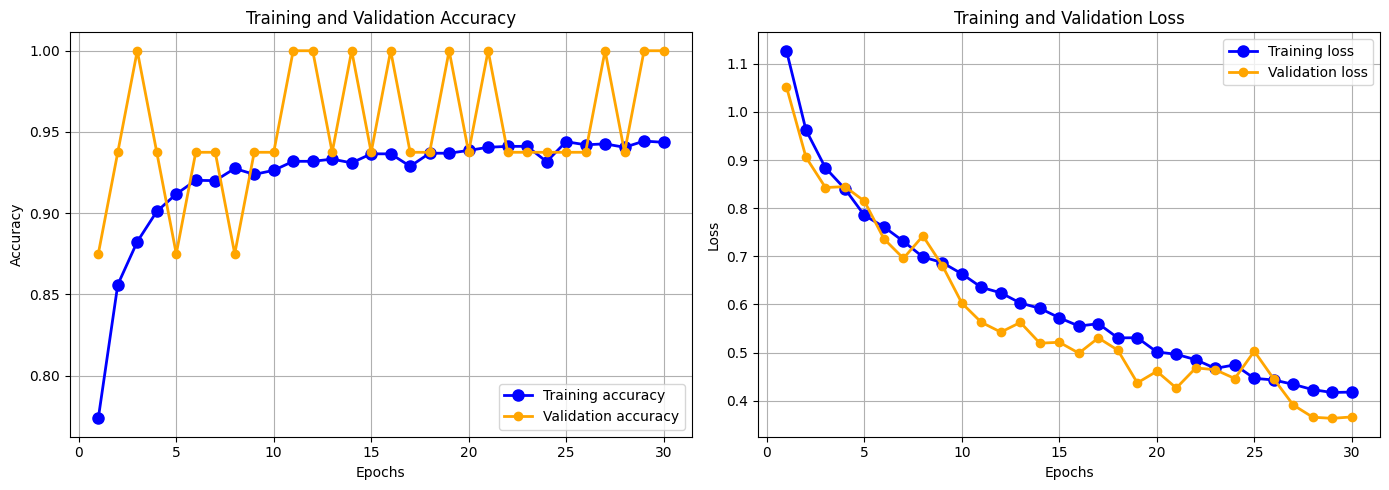

In [13]:
# Extracting data from the new model's history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy on the first subplot (left) with blue and orange colors
ax1.plot(epochs, accuracy, marker="o", linestyle="-", label="Training accuracy", markersize=8, linewidth=2,
         color="blue")
ax1.plot(epochs, val_accuracy, marker="o", linestyle="-", label="Validation accuracy", linewidth=2, color="orange")
ax1.set_title("Training and Validation Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True)

# Plot loss on the second subplot (right) with blue and orange colors
ax2.plot(epochs, loss, marker="o", linestyle="-", label="Training loss", markersize=8, linewidth=2, color="blue")
ax2.plot(epochs, val_loss, marker="o", linestyle="-", label="Validation loss", linewidth=2, color="orange")
ax2.set_title("Training and Validation Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

The training and validation metrics have been visualized.

**Analysis:**
- The **training accuracy** steadily improves over the epochs, reaching a plateau around 15 epochs and maintaining consistency thereafter. This indicates that the model effectively learns patterns in the training data without significant overfitting.
- The **validation accuracy** starts high and remains stable across most epochs, with slight fluctuations but consistently near-perfect performance in later epochs. This stability suggests strong generalization to the validation set.
- The **training loss** shows a smooth and gradual decline over the epochs, aligning well with the improvement in training accuracy.
- The **validation loss** generally trends downward, with only minor fluctuations, reaching a low point toward the end of training. This indicates that the model effectively minimizes error on the validation data as training progresses.

These trends reflect a well-performing model with good generalization to the validation set. The stable metrics suggest no immediate need for additional regularization or hyperparameter tuning.

Next, we will evaluate the model on the test dataset to assess its performance on unseen data.

#### 4.2 Evaluating the Model

In this step, we will load the best-performing model (as determined by the lowest validation loss during training) and evaluate its performance on the test dataset. This evaluation will provide a measure of the model's generalization ability and its effectiveness in classifying unseen data.

In [14]:
# Load the best model
model = load_model("../Models/Chest_X-Ray_Pneumonia_Detection_Model.keras")

# Evaluate the model on the test dataset
loss, accuracy, precision, recall = model.evaluate(test_dataset, verbose=0)

# Print the evaluation metrics
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy * 100:.2f}%, Loss: {loss:.4f}")

Precision: 0.8556, Recall: 0.9872, Accuracy: 88.78%, Loss: 0.5720


The model has been evaluated on the test dataset, achieving the following performance metrics:

- **Precision:** 0.8556
- **Recall:** 0.9872
- **Accuracy:** 88.78%
- **Loss:** 0.5720

These results demonstrate that the model performs well on unseen data, with high recall ensuring it detects most Pneumonia cases. However, the precision and loss metrics suggest there is room for improvement in reducing false positives and further optimizing the model.

Next, let's examine some of the incorrectly classified images to better understand the model's limitations.

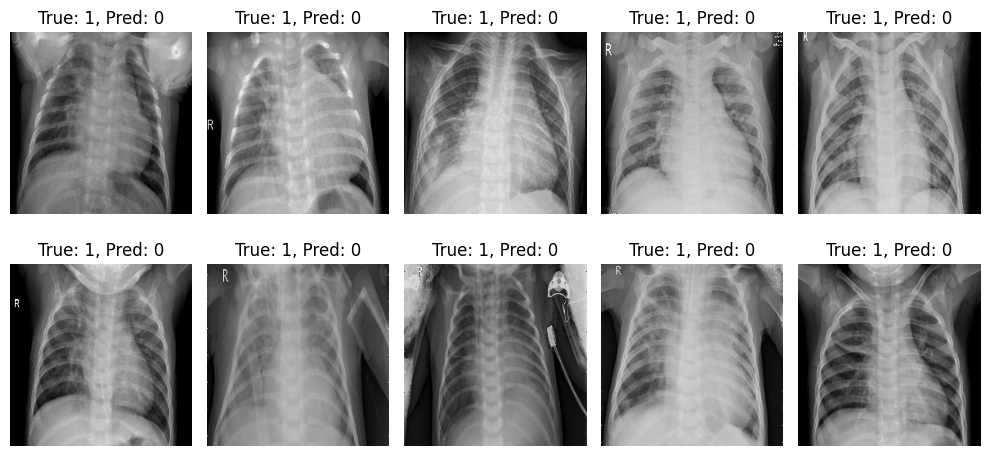

In [15]:
# Get the predictions from the model
predictions = model.predict(test_dataset, verbose=0)

# Convert probabilities to binary labels (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels and images from the dataset
true_labels = []
images = []

for image_batch, label_batch in test_dataset:
    images.extend(image_batch.numpy())  # Collect images
    true_labels.extend(label_batch.numpy())  # Collect true labels

# Convert true labels to a numpy array (no need for argmax)
true_labels = np.array(true_labels)

# Identify misclassified images
wrong_indices = np.where(predicted_labels != true_labels)[0]

# Display some of the wrongly identified images
num_images = min(10, len(wrong_indices))  # Limit to 10 images for display
plt.figure(figsize=(10, 5))

for i, idx in enumerate(wrong_indices[:num_images]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx].astype("uint8"))  # Convert image data to displayable format
    plt.title(f"True: {true_labels[idx]}, Pred: {predicted_labels[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

The model has misclassified some images as `Normal` (Pred: 0) when they are actually `Pneumonia` (True: 1). Potential reasons for these misclassifications include:

1. **Subtle Pneumonia Indicators:** The signs of Pneumonia in these X-rays might be very subtle or located in regions where the model is less sensitive, leading to misclassification.

2. **Overlapping Features:** The images may contain overlapping features with `Normal` class X-rays, such as clear lung regions or minimal opacities, making it challenging for the model to distinguish between the two classes.

3. **Quality and Artifacts:** Some X-rays may have poor image quality, artifacts (e.g., medical equipment, noise), or inconsistent lighting that could confuse the model.

4. **Class Imbalance Sensitivity:** Despite class weighting, the model may still struggle to correctly classify cases from the minority class (`Normal`), especially in borderline or ambiguous instances.

5. **Model Limitations:** The model might have insufficient feature extraction capabilities or may not have been exposed to enough diverse training examples of Pneumonia with similar visual patterns.

Understanding these limitations emphasizes the importance of further improving the model through techniques such as enhanced data augmentation, additional training data, or fine-tuning hyperparameters.

Next, we will calculate the F1-Score to further evaluate the model's performance.

#### 4.3 F1 Score

In this step, we will calculate the F1-Score to evaluate the balance between precision and recall. The F1-Score is particularly useful in cases of class imbalance, as it provides a single metric that accounts for both false positives and false negatives. This will give us a more comprehensive understanding of the model's performance in detecting Pneumonia.

In [17]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # True labels
    preds = model.predict(images, verbose=0)  # Predicted probabilities with no output
    y_pred.extend((preds > 0.5).astype(int).flatten())  # Convert probabilities to binary (0 or 1)

# Calculate F1-Score
f1 = f1_score(y_true, y_pred)
print(f"F1-Score: {f1:.4f}")

F1-Score: 0.9167


The F1-Score for the model is **0.9167**, indicating a good balance between precision and recall in detecting Pneumonia.

Next, we will plot the ROC curve and calculate the Area Under the Curve (AUC) to further evaluate the model's classification performance.

#### 4.4 ROC Curve and AUC

We will plot the ROC curve and calculate the AUC for the model.

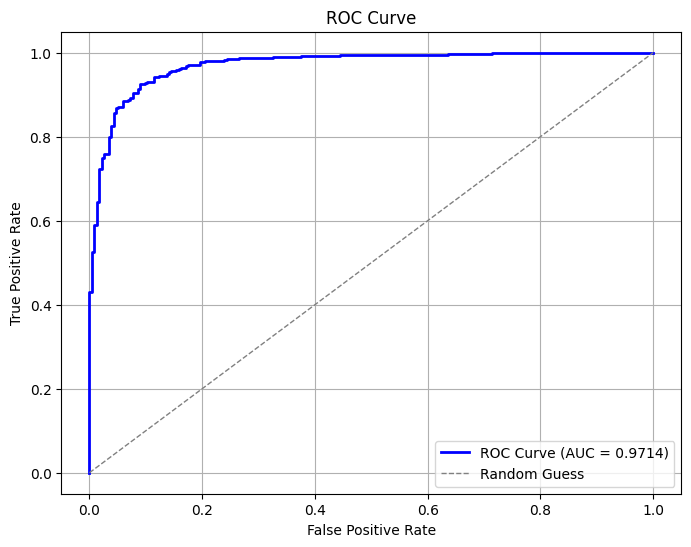

In [18]:
y_true = []
y_probs = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # True binary labels (0 or 1)
    preds = model.predict(images, verbose=0)  # Predicted probabilities
    y_probs.extend(preds.flatten())  # Flatten probabilities to a 1D array

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

The ROC curve has been plotted, and the Area Under the Curve (AUC) is **0.9714**.

**Analysis:**
- The ROC curve demonstrates excellent performance, as it remains close to the top-left corner, indicating a high true positive rate and a low false positive rate across different thresholds.
- The AUC value of **0.9714** reflects the model's strong ability to distinguish between `Pneumonia` and `Normal` cases. A value close to 1.0 indicates near-perfect classification capability.
- The slight curvature away from the ideal top-left corner suggests minor room for improvement, particularly in handling edge cases where predictions may be less confident.

Next, we will plot the confusion matrix to examine the model's classification results in detail.

#### 4.5 Confusion Matrix

In this step, we will plot the confusion matrix to evaluate the model's classification performance in terms of true positives, true negatives, false positives, and false negatives. This visualization will provide insights into the types of errors the model makes and help identify areas for improvement.

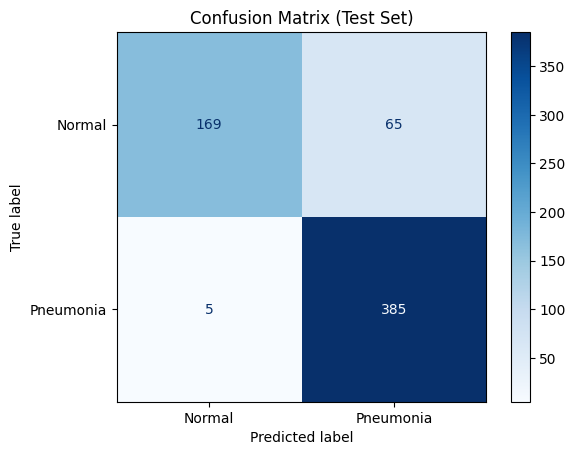

In [20]:
# Get the true labels and predicted probabilities for the test set
y_true = []
y_pred_prob = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Collect true binary labels
    y_pred_prob.extend(model.predict(images, verbose=0).flatten())  # Predict probabilities for the positive class

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Get class predictions based on a threshold (default 0.5)
y_pred_classes = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()

The confusion matrix has been plotted, and the model has performed well.

**Analysis:**
- The model correctly classified **169 Normal cases** and **385 Pneumonia cases**.
- There are **65 false positives**, where Normal cases were misclassified as Pneumonia.
- There are only **5 false negatives**, where Pneumonia cases were misclassified as Normal.

This indicates that the model has a high sensitivity (low false negatives), which is critical in medical applications like Pneumonia detection, where missing a Pneumonia case could have severe consequences. However, the relatively higher number of false positives suggests the need for further optimization to reduce unnecessary follow-up actions on Normal cases.

### 5. Medical Insights

The model has been successfully developed to detect Pneumonia from X-ray images, achieving an accuracy of **88.78%** on the test dataset. The F1-Score is **0.9167**, and the AUC is **0.9714**, demonstrating strong performance in balancing precision and recall, as well as excellent discriminatory ability between `Normal` and `Pneumonia` cases. The confusion matrix highlights the model's ability to correctly classify the majority of cases, with a high true positive rate and a low false negative rate, ensuring most Pneumonia cases are accurately identified.

#### 5.1 Ethical Considerations
The use of artificial intelligence in medical diagnosis raises important ethical considerations that must be addressed for responsible deployment:

1. **Reliability and Accountability:**
   - The model’s predictions must be consistently accurate and validated by medical experts. Errors, particularly false negatives, could delay critical treatment and adversely affect patient outcomes.

2. **Bias and Fairness:**
   - The training data should represent diverse populations to prevent biases related to demographic, geographic, or socioeconomic factors. A lack of diversity in the dataset could lead to inequitable healthcare outcomes for underrepresented groups.

3. **Transparency and Explainability:**
   - It is vital to ensure that clinicians understand how the model arrives at its predictions. Transparent models are more likely to be trusted and responsibly used in clinical practice.

4. **Regulation and Oversight:**
   - There must be clear regulatory guidelines for the development and use of AI in healthcare to ensure safety, efficacy, and accountability.

5. **Human Oversight:**
   - The model should always act as a support tool for clinicians, rather than replacing expert medical judgment. Decisions about diagnosis and treatment should always involve qualified healthcare professionals who can interpret the model’s predictions in the context of patient history and clinical findings.

These ethical considerations emphasize the need for cautious and deliberate use of AI in medicine to ensure equitable, safe, and effective outcomes for all patients.

### 6. Conclusion

The model has demonstrated strong potential in detecting Pneumonia from X-ray images. With an accuracy of **88.78%**, an F1-Score of **0.9167**, and an AUC of **0.9714**, it shows promise as a decision-support tool for radiologists. The model could assist in reducing the workload of radiologists, providing faster preliminary diagnoses, and improving consistency in Pneumonia detection.

In real-world applications, this model could be integrated into clinical workflows as a tool to prioritize cases or provide a second opinion. However, it is crucial that the model’s outputs are interpreted alongside expert medical advice to ensure patient safety and care quality.

#### Future Prospects
While further development of this specific model is not planned, future AI models in similar domains **could be** improved by:
- Expanding their scope to detect a wider range of abnormalities, such as tuberculosis, lung cancer, or chronic obstructive pulmonary disease (COPD).
- Incorporating larger, more diverse datasets to enhance generalizability across populations.
- Developing explainable AI frameworks to improve transparency and trust among clinicians and patients.
- Deploying the models as web or mobile applications to enhance accessibility for healthcare providers in resource-limited settings.

This project highlights the potential of AI in healthcare, but it also underscores the importance of ethical considerations, transparency, and human oversight to ensure these tools are used responsibly and effectively in clinical practice.
